In [24]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import matplotlib.pylab as pylab
import cartopy.feature as cfeature
import scipy.stats as stats
import xarray as xr
import ipdb
import glob
import itertools
import numpy.ma as ma
from utils import u_statistics as u_stat
from scipy.stats import gaussian_kde
import pickle as pkl
from utils import u_plot as uplot, u_darrays as uda, u_met
import pandas as pd
import salem

##for regridding, install xesmf:
# conda install esmpy
# pip install xesmf
from utils import constants as cnst

pylab.rcParams['figure.figsize'] = (30., 30.)
#%matplotlib inline

In [23]:
cd ..

/home/ck/pythonWorkspace


In [25]:
pdf = pkl.load(open (cnst.CLOVER_SAVES + 'StormLoc_-50_5000km_WA.p', 'rb'))

In [26]:
shdf = salem.read_shapefile(salem.get_demo_file('ne_50m_ocean.shp'))

In [27]:
pdf = pdf.where((pdf.clat>=4.5) & (pdf.clat<=15) & (pdf.clon>=-10) & (pdf.clon<=10) &
(pdf.year >=2000) & (pdf.year <=2012))

In [28]:
era_srfc = xr.open_dataset(cnst.ERA5_MONTHLY_SRFC_SYNOP)
era_pl = xr.open_dataset(cnst.ERA5_MONTHLY_PL_SYNOP)

In [29]:
era_pl = uda.flip_lat(era_pl)
era_srfc = uda.flip_lat(era_srfc)

In [30]:
chirps = xr.open_mfdataset(cnst.CHIRPS_MONTHLY + "*.nc", concat_dim='time',autoclose=True)
chirps = uda.flip_lat(chirps)

In [31]:
chov = chirps.sel(lat=slice(4.5,14.5), lon=slice(-10,10)).groupby('time.month').mean('time')
chirps_grid = chov.salem.grid
chirps_roi = chirps_grid.region_of_interest(shape=shdf)
chirps_roi = (chirps_roi-1)*-1

In [32]:
chov = chov.where(chirps_roi)
chov = chov.mean('lon')

In [33]:
s40 =     pkl.load(open(cnst.network_data + 'data/CLOVER/saves/storm_HOVcount_10W-12E_5-8N_-40C_5000km2_18.p',
                        'rb'))

s50 =     pkl.load(open(cnst.network_data + 'data/CLOVER/saves/storm_HOVcount_10W-12E_5-8N_-50C_5000km2_18.p',
                        'rb'))
s60 =     pkl.load(open(cnst.network_data + 'data/CLOVER/saves/storm_HOVcount_10W-12E_5-8N_-60C_5000km2_18.p',
                        'rb'))
s70 =     pkl.load(open(cnst.network_data + 'data/CLOVER/saves/storm_HOVcount_10W-12E_5-8N_-70C_5000km2_18.p',
                        'rb'))
s75 =     pkl.load(open(cnst.network_data + 'data/CLOVER/saves/storm_HOVcount_10W-12E_5-8N_-75C_5000km2_18.p',
                        'rb'))

In [34]:
test = np.vstack(s70[5]).mean(axis=0)
test2 = np.vstack(s50[5]).mean(axis=0)

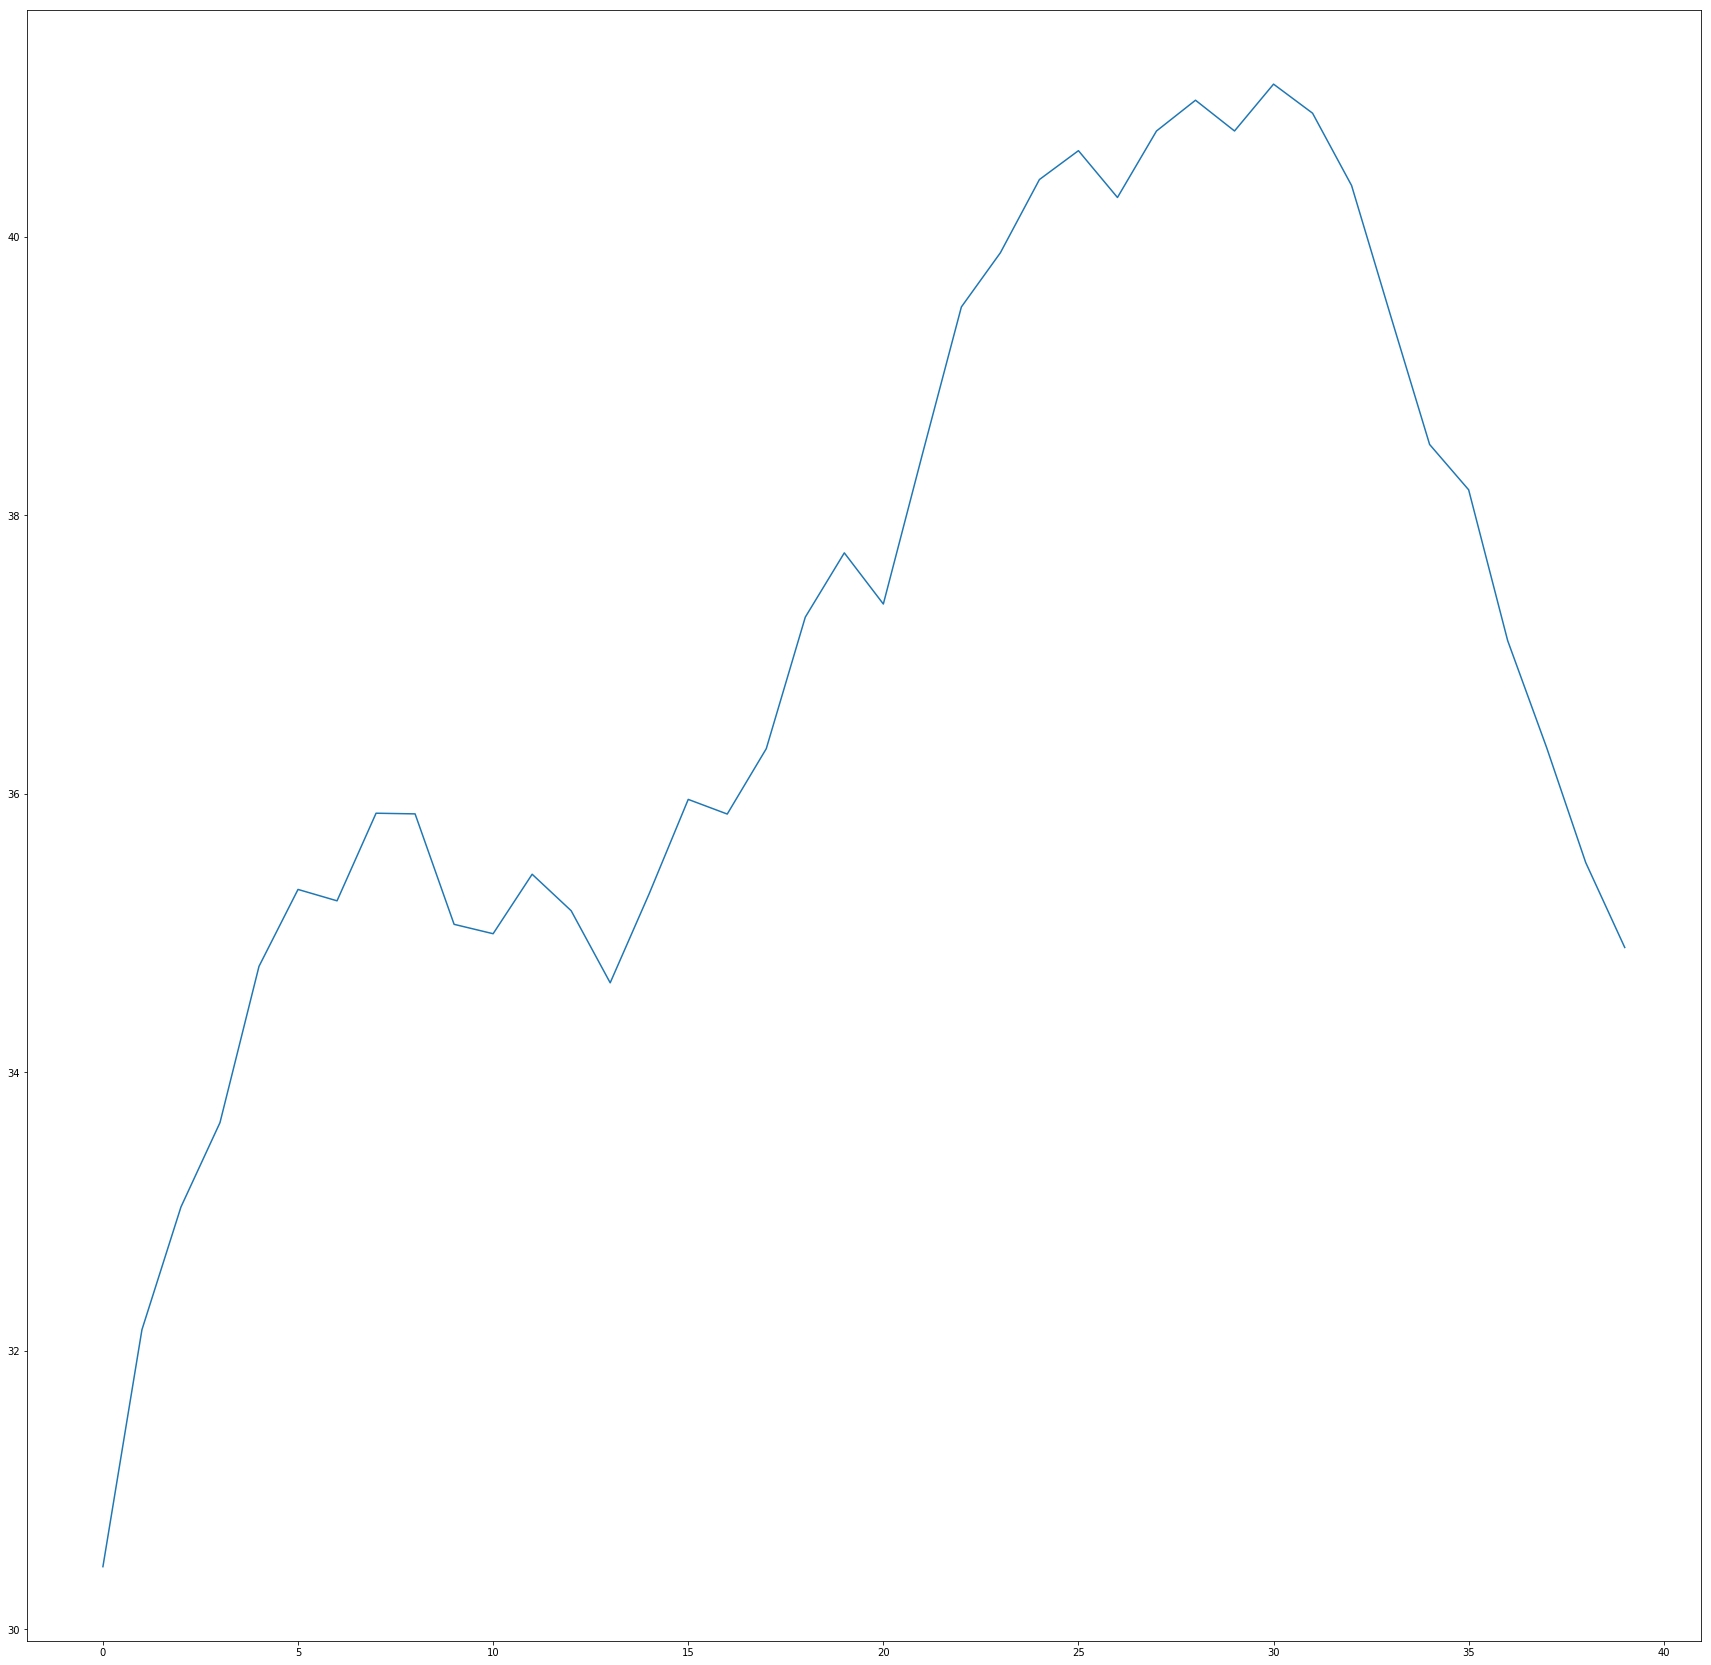

In [35]:
plt.plot((test/test2)*100)

In [36]:
s1=-12
s2=9
ar = xr.open_dataarray(cnst.GRIDSAT + 'aggs/WAbox_meanT-50_hov_5000km2.nc')
mean = ar.mean('year').sel(lat=slice(4.5,14.5))
ar70 = xr.open_dataset(cnst.GRIDSAT + 'aggs/gridsat_WA_-70_monthly_mean_5000km2.nc')
ar50 = xr.open_dataset(cnst.GRIDSAT + 'aggs/gridsat_WA_-50_monthly_count.nc')
ar70c = xr.open_dataset(cnst.GRIDSAT + 'aggs/gridsat_WA_-70_monthly_count_5000km2.nc')
ar40 = xr.open_dataset(cnst.GRIDSAT + 'aggs/gridsat_WA_-40_monthly_count_-40base_1000km2.nc')
ar70 = ar70['tir'].sel(lon=slice(s1,s2), lat=slice(4.5,14.5)).groupby('time.month').mean('time').mean('lon')
ar70c = ar70c['tir'].sel(lon=slice(s1,s2), lat=slice(4.5,14.5)).groupby('time.month').mean('time').mean('lon')
ar50 = (ar50['tir'].sel(lon=slice(s1,s2), lat=slice(4.5,14.5))).groupby('time.month').mean('time').mean('lon')
ar40 = (ar40['tir'].sel(lon=slice(s1,s2), lat=slice(4.5,14.5))).groupby('time.month').mean('time').mean('lon')

In [37]:
ar50diff = ar50-ar70c

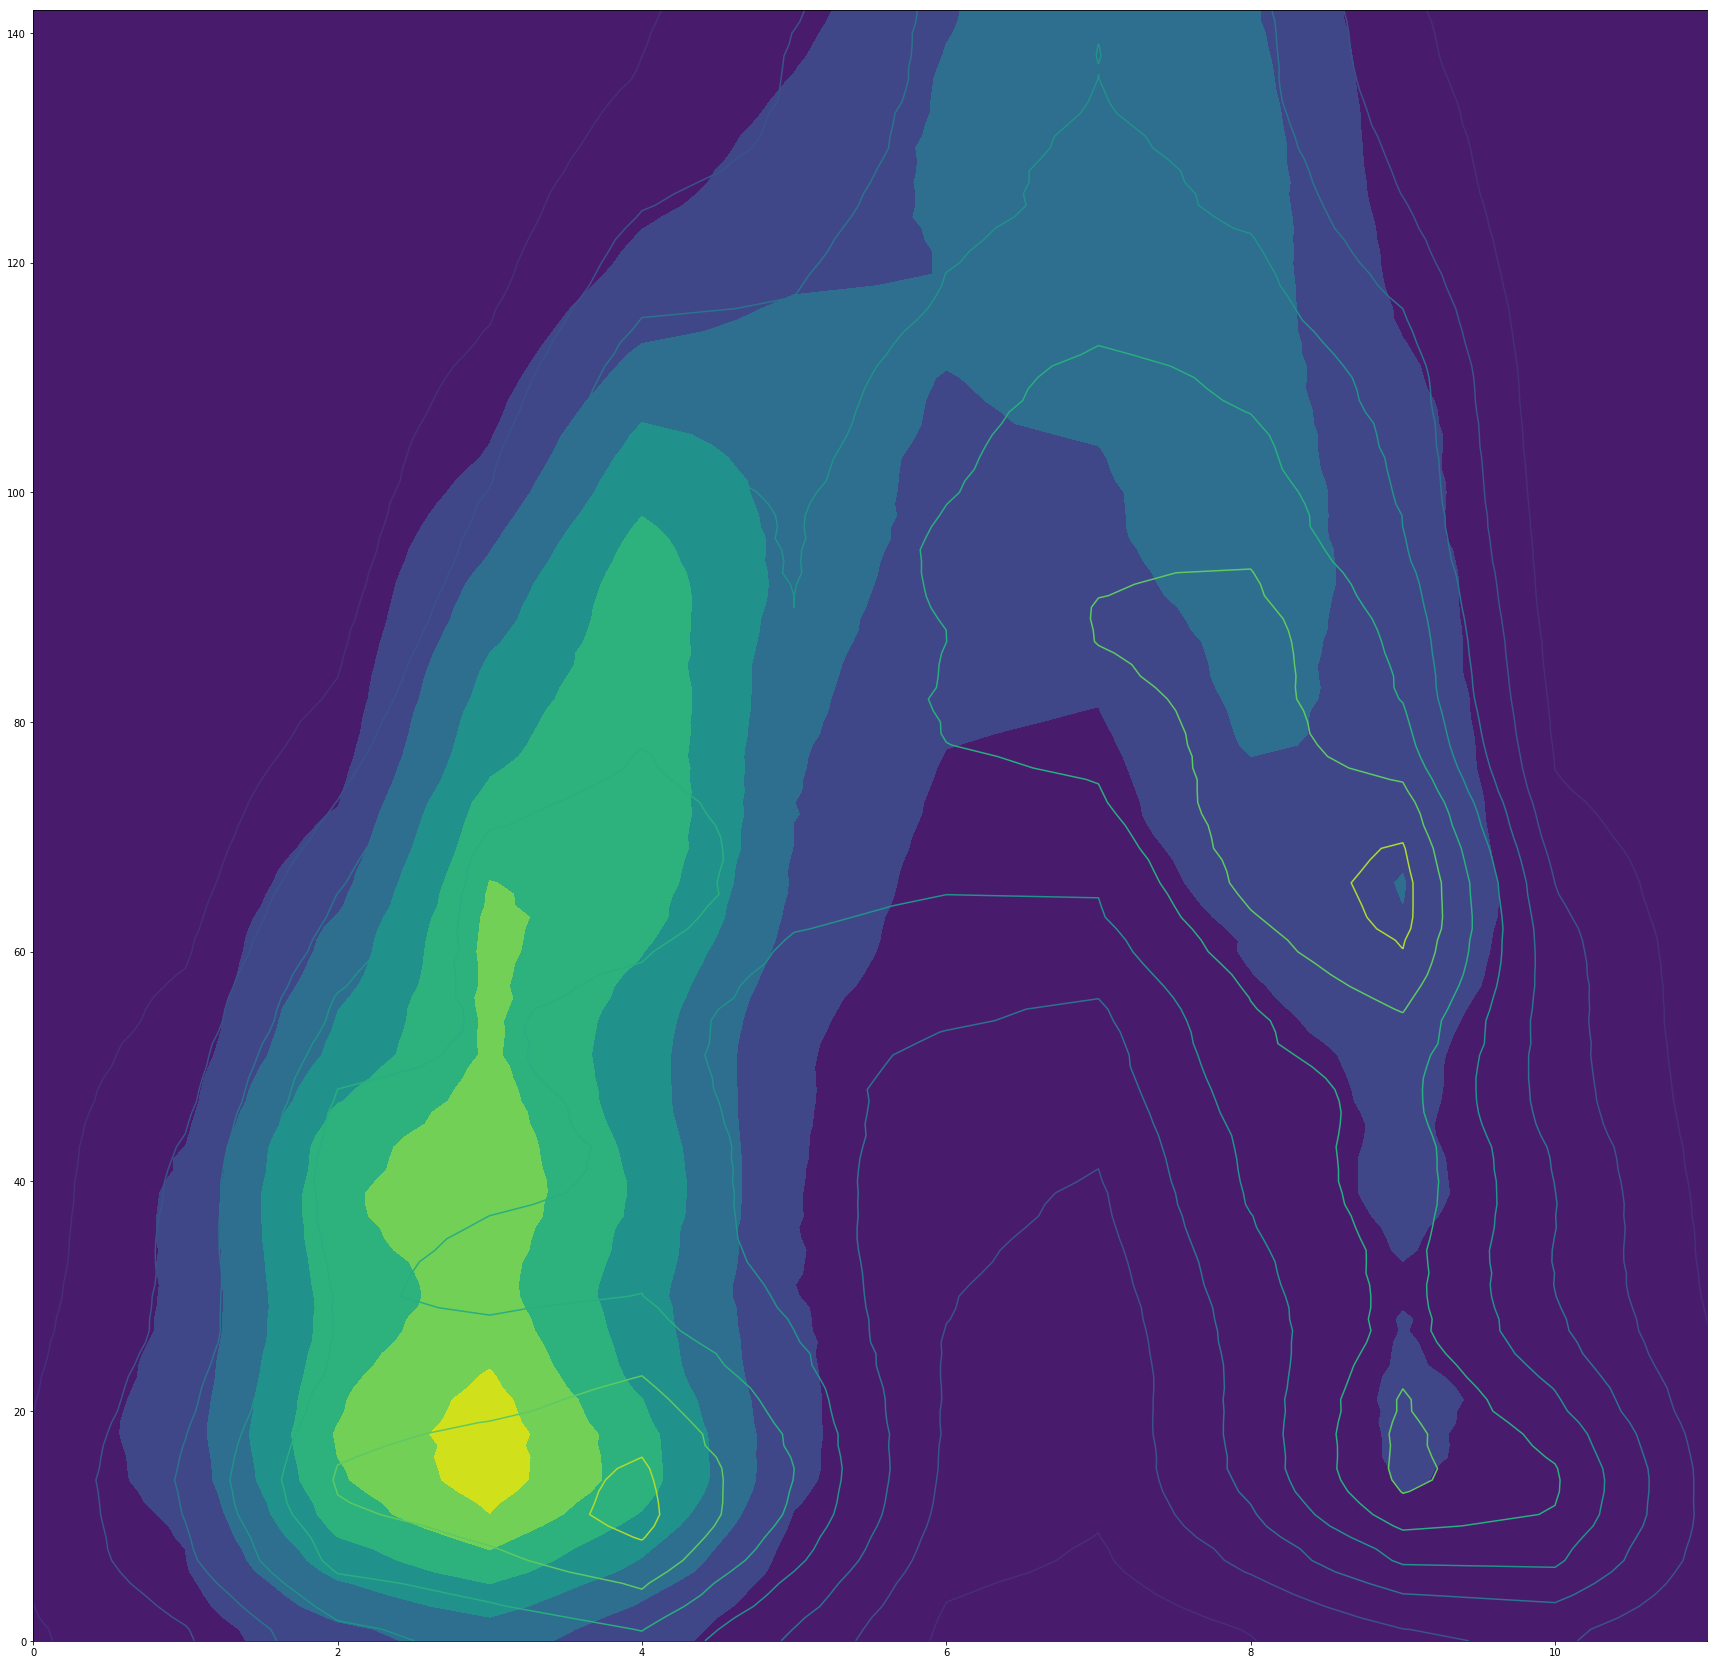

In [38]:
plt.contourf(ar70c.T)
plt.contour(ar50diff.T)

In [39]:
OBS2 = pkl.load( open (cnst.CLOVER_SAVES + 'bulk_-50_5000km2_GPM_ERA-I.p', 'rb'))
OBS1 = pkl.load( open (cnst.CLOVER_SAVES + 'bulk_-70_5000km2_GPM_ERA-I.p', 'rb'))
def create_dic(dic):
    pp = np.array(dic['pmax'])
    sh = np.array(dic['shear']) #np.array(dic['shear']) * (-1)
    umin = np.array(dic['u650'])
    umax = np.array(dic['u925'])
    qq = np.array(dic['q925']) 
    tt = np.array(dic['tmin'])
    ttm = np.array(dic['tmean'])
    month = np.array(dic['month'])
    area = np.array(dic['area'])
    lat = np.array(dic['clat'])
    lon = np.array(dic['clon'])

    obs_pcp = {
        'prcp' : pp,
        'u650' : umin,
        'u925' : umax,
        'q925' : qq*1000,
        'shear' : sh*-1,
        'month' : month,
        'area' : (area)*(5**2),
        'tmin' : tt,
        'tmean' : ttm,
        'lat' : lat,
        'lon' : lon,
    } 
    obs = pd.DataFrame(obs_pcp)
    return obs
obs_gpm = create_dic(OBS2)
obs_gpm70 = create_dic(OBS1)

In [40]:
obs_gpm70.lat.max()

8.72524198343167

In [41]:
obs_gpm = obs_gpm[(obs_gpm.lon>=-10)&(obs_gpm.lon<=10)]
obs_gpm70 = obs_gpm70[(obs_gpm70.lon>=-10)&(obs_gpm70.lon<=10)]

In [42]:
lats = np.arange(4.5,9.1,0.5)
dic = {3 : [], 4:[], 5:[], 6:[], 7:[], 8:[], 9:[], 10:[], 11:[]}
dic_mean = {3 : [], 4:[], 5:[], 6:[], 7:[], 8:[], 9:[], 10:[], 11:[]}
dic_abs = {3 : [], 4:[], 5:[], 6:[], 7:[], 8:[], 9:[], 10:[], 11:[]}
dic_70 = {3 : [], 4:[], 5:[], 6:[], 7:[], 8:[], 9:[], 10:[], 11:[]}
gpmlist = []
for k in dic.keys():
    for ids, ll in enumerate(lats[0:-2]):
        #print('between', ll, lats[ids+1])
        storms = obs_gpm[(obs_gpm.lat>=ll)&(obs_gpm.lon<=lats[ids+1])&(obs_gpm.month==k)]
        storms70 = obs_gpm70[(obs_gpm70.lat>=ll)&(obs_gpm70.lon<=lats[ids+1])&(obs_gpm70.month==k)]
        summi = np.sum((storms['prcp']>50))/np.sum((storms['prcp']>0))
        summi70 = np.sum((storms70['prcp']>50))/np.sum((storms['prcp']>50))
        dic[k].append(summi)
        dic_mean[k].append(np.sum((storms['prcp']>0)))
        dic_abs[k].append(np.sum((storms['prcp']>50)))
        dic_70[k].append(summi70)
latbin = lats[1:-1]-0.25

/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in long_scalars
  del sys.path[0]


In [43]:
len(dic[6])

8

In [44]:
np.repeat(vdic['ERA_srfc']['t2m'].values, repeats = len(vdic['ERA_pl'].level), axis=0).reshape((len(vdic['ERA_pl'].level), len(vdic['ERA_srfc']['t2m'].values)))

NameError: name 'vdic' is not defined

In [45]:
## a clean way of plotting - use matplotlib functions directly:

def draw_cross(ax, data, lon, lat, title=None, xlabel=None, ylabel=None,  cmap=None,mask_sig=None, quiver=None, contour=None, cbar_label=None, twinx=None, cbar=True,**kwargs):

    mapp = ax.contourf(lon, lat, data, extend='both', alpha=0.75, cmap=cmap, **kwargs)  # this is the actual plot
    
#     cmapp = uplot.discrete_cmap(25, base_cmap=cmap)
#     mapp = ax.pcolormesh(lon, lat,data,cmap=cmapp, vmin=50, vmax=68)
    
    plt.gca().invert_yaxis()
    if mask_sig is not None:
         plt.contourf(lon, lat, mask_sig, colors='none', hatches='.',
                     levels=[0.5, 1], linewidth=0.1)
    
    if quiver is not None:
        qu = ax.quiver(quiver['x'], quiver['y'], quiver['u'], quiver['v'], scale=quiver['scale'], width=0.002)
        
    if contour is not None:
        cs = ax.contour(contour['x'], contour['y'], contour['data'], levels=contour['levels'], cmap=contour['cmap'], linewidths=0.8 )
        plt.clabel(cs, inline=1, fontsize=10)
        
    if twinx is not None:
        ax1 = ax.twinx()
        ax1.plot(twinx['x'], twinx['y'], twinx['color'] )
        ax1.set_ylabel(twinx['ylabel'])
        ax1.set_ylim(twinx['ylim'][0], twinx['ylim'][1])
    
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    if cbar:
        cbar = plt.colorbar(mapp, pad=0.09, format='%d')  # adds colorbar
        #cbar = plt.colorbar(mapp, ticks=np.linspace(50,68,25), pad=0.09)
        cbar.set_label(cbar_label)
    
    #return mapp


In [46]:
era_pl['ymonth'] = ('time', [str(m)+'-'+str(h) for (m,h) in zip(era_pl['time.month'].values,era_pl['time.hour'].values)])
grouped='ymonth'
era_pl_cross =  era_pl.groupby(grouped).mean(dim='time')

In [47]:
era_srfc['ymonth'] = ('time', [str(m)+'-'+str(h) for (m,h) in zip(era_srfc['time.month'].values,era_srfc['time.hour'].values)])
grouped='ymonth'
era_srfc_cross =  era_srfc.groupby(grouped).mean(dim='time')

/home/ck/miniconda3/lib/python3.5/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [48]:
def sel_month(m1):

    cross_march = era_pl_cross.sel(ymonth=str(m1)+'-12', longitude=slice(-10,10), latitude=slice(3.5,15)).mean('longitude')
    cross_marchs = era_srfc_cross.sel(ymonth=str(m1)+'-12', longitude=slice(-10,10), latitude=slice(3.5,15)).mean('longitude')
    cross_m_shear = cross_march.sel(level=650)-cross_march.sel(level=900)
    
    cross_mse = u_met.moist_static_energy(cross_march['t'].values-273.15, cross_march['q'].values, geop=cross_march['z'].values)
    cross_dse = u_met.dry_static_energy(cross_march['t'].values-273.15, geop=cross_march['z'].values)
    cross_theta = u_met.theta(era_pl_cross.level.values, cross_march['t'].values-273.15)
    cross_theta_e = u_met.theta_e(era_pl_cross.level.values, cross_march['t'].values-273.15, cross_march['q'].values)
    
    cross_prcp_march = chov.sel(month=m1)
    cross_meanT_march = mean.sel(month=m1)
    cross_70_march = ar70c.sel(month=m1)
    cross_50_march = ar50.sel(month=m1)
    cross_40_march = ar40.sel(month=m1)
    cross_50_no70 = ar50diff.sel(month=m1)
    ext_frac_m = dic[m1]
    ext_mean_m = dic_mean[m1]
    ext_abs_m = dic_abs[m1]
    ext_70_m = dic_70[m1]
    
    return {
       'ERA_pl' : cross_march,
        'ERA_srfc' : cross_marchs,
        'ERA_shear' : cross_m_shear,
        'CHIRPS' : cross_prcp_march,
        'meanT_-50' : cross_meanT_march,
        'cover70' : cross_70_march,
        'cover50' : cross_50_march,       
        'cover40' : cross_40_march,  
        'cover50no70' : cross_50_no70, 
        'extremeFrac70' : ext_frac_m,
        'noZero70' : ext_mean_m,
        'extremeAbs70' : ext_abs_m,
        'extreme70Frac50' : ext_70_m,
        'mse' : cross_mse,
        'dse' : cross_dse,
        'theta' : cross_theta,
        'theta_e' : cross_theta_e
    }

In [49]:
vdic['ERA_pl'].level

NameError: name 'vdic' is not defined

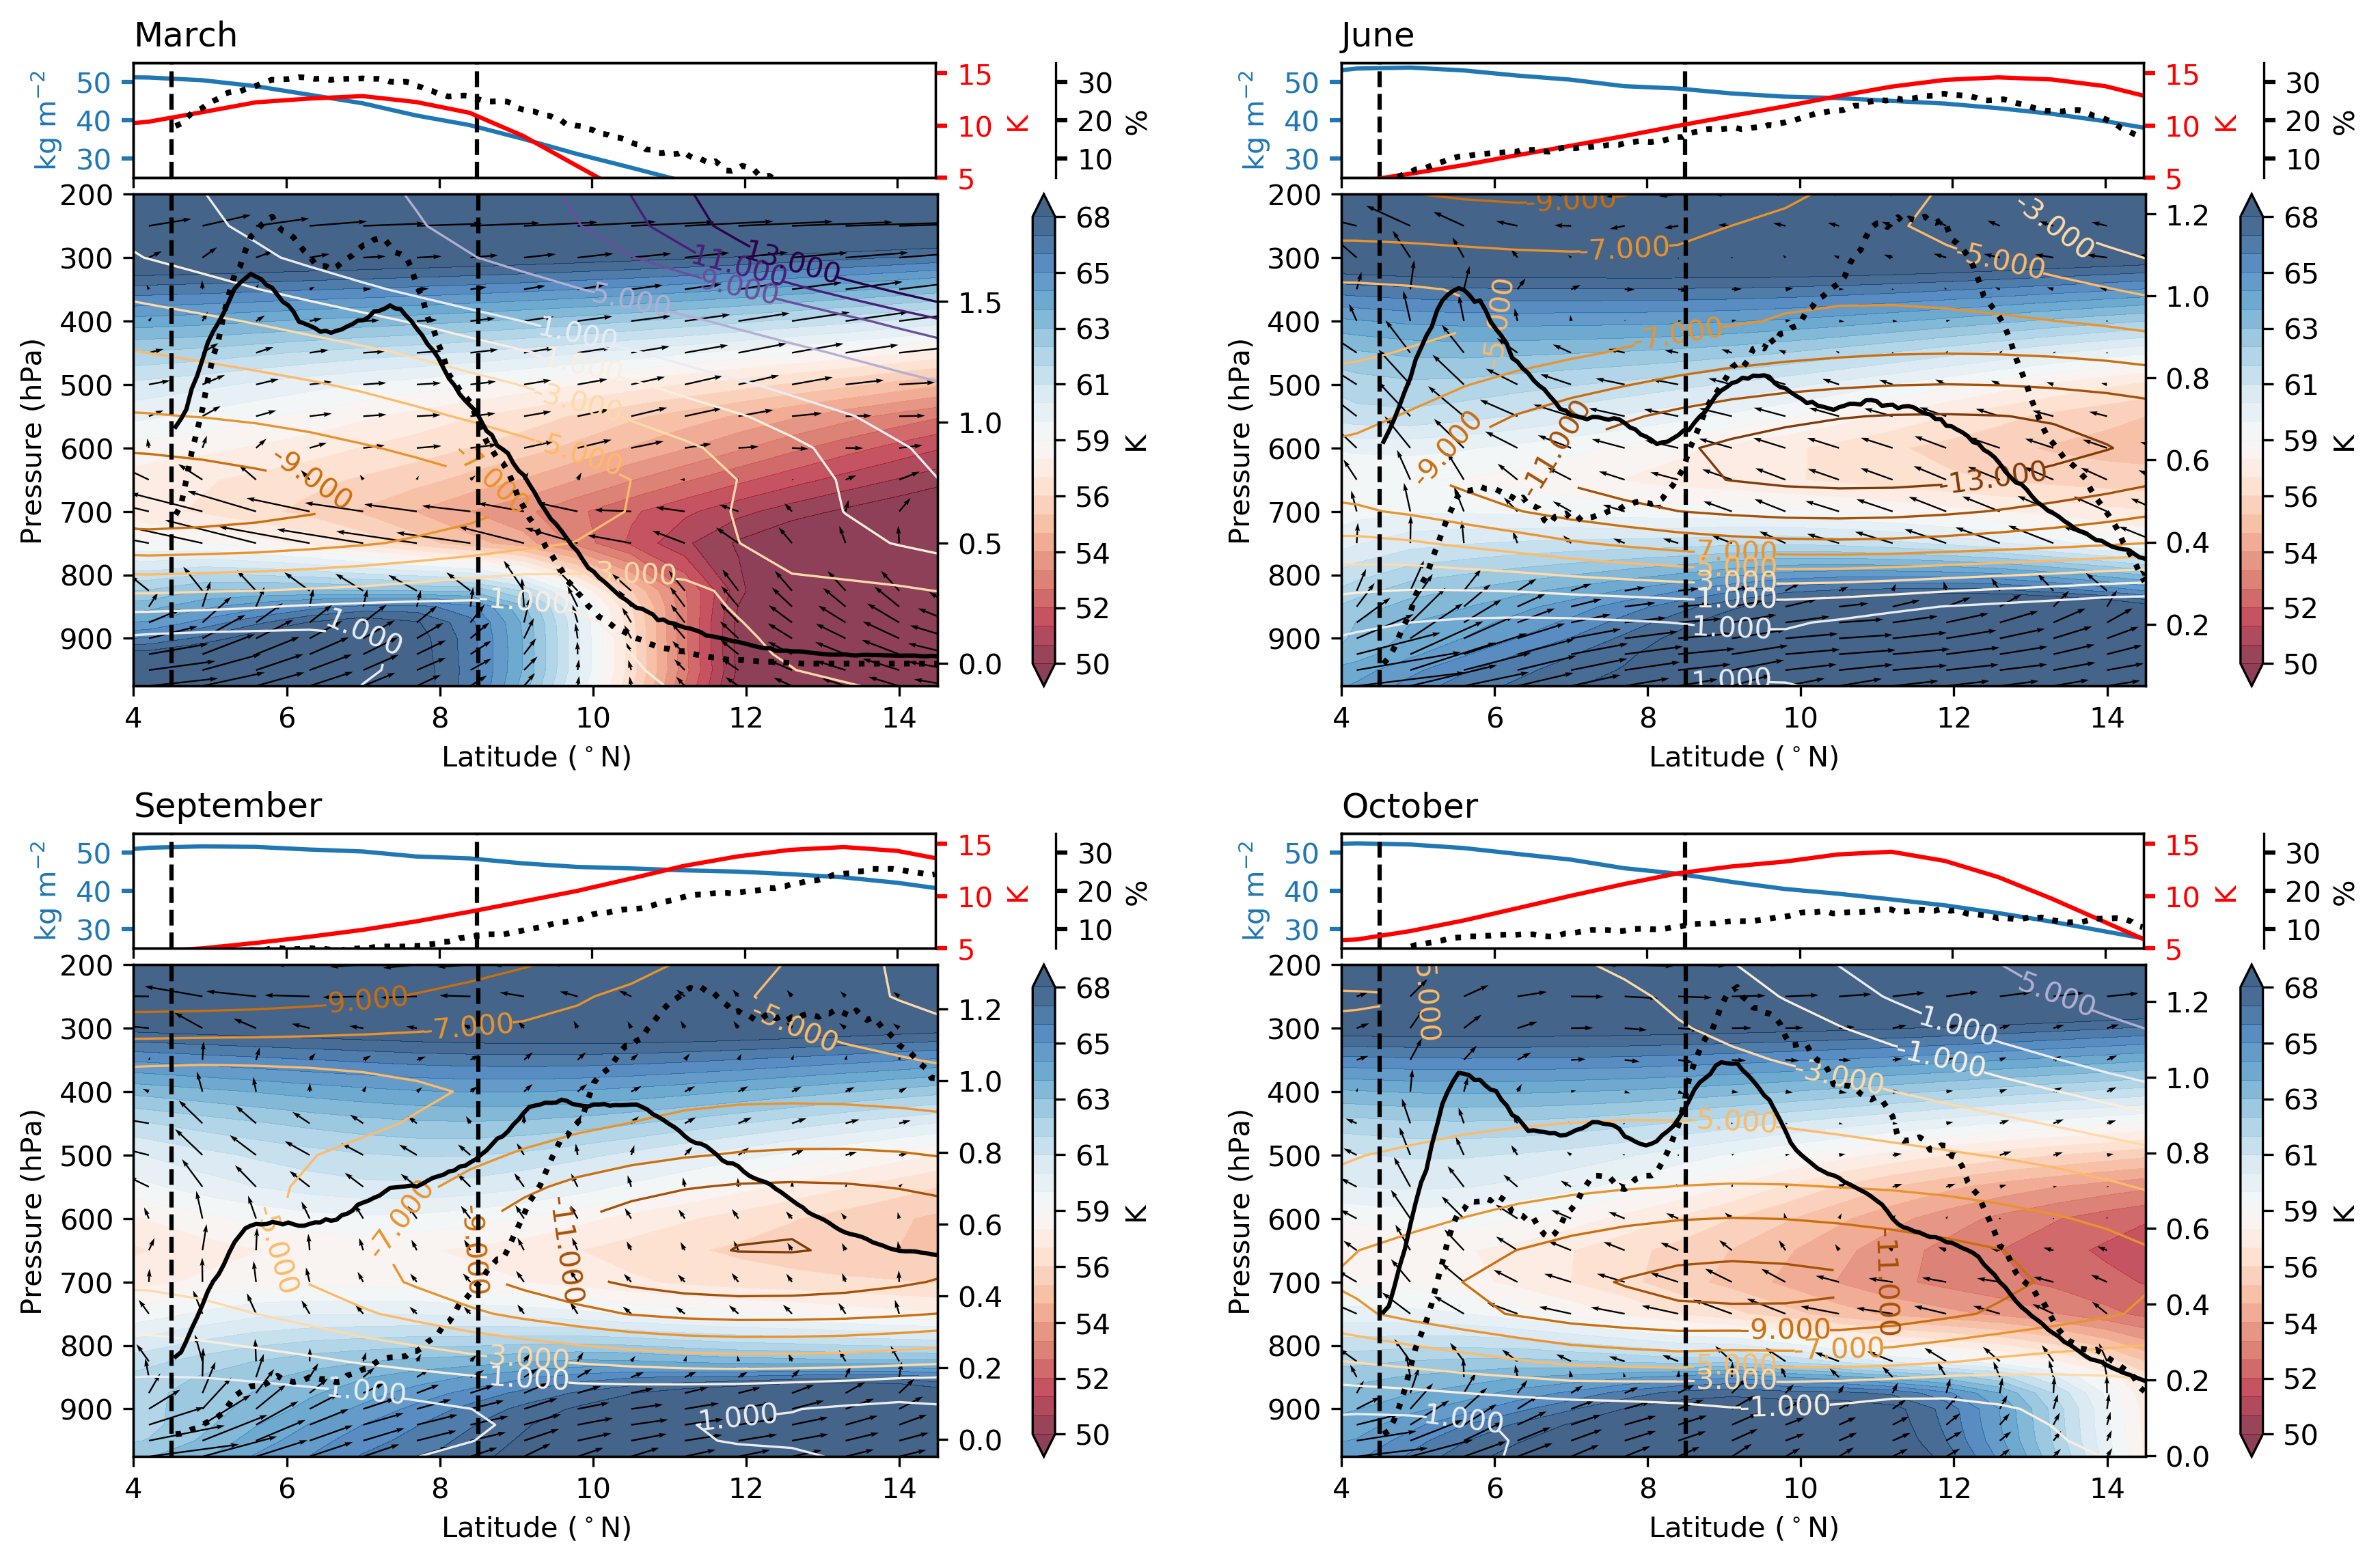

In [50]:

f=plt.figure(figsize=(12,8), dpi=300)  # this opens a plot window

left, width, width2 = 0.061, 0.43, 0.326#0.345
space=0.01
left2 = left + width + left

bottom, height, height2 = 0.07, 0.3, 0.07
bottom1 = bottom + height + space


bottom2 = bottom+height + height2 + space*10
bottom22 = bottom2  + height + space

cross1 = [left, bottom, width, height]
cross2 = [left+width+left, bottom, width, height]
line1 = [left, bottom1, width2, height2]
line2 = [left+width+left, bottom1, width2, height2]

cross3 = [left, bottom2, width, height]
cross4 = [left+width+left, bottom2, width, height]
line3 = [left, bottom22, width2, height2]
line4 = [left+width+left, bottom22, width2, height2]

pdic = {3 : (cross3,line3,'March'), 6 : (cross4, line4,'June'), 9 : (cross1, line1,'September'), 10 : (cross2, line2,'October') }

for k in pdic.keys():#ids, m in enumerate(np.array([3,6,9,10])):
    
    m = k
    p1 = pdic[k][0]
    p2 = pdic[k][1]
    mname = pdic[k][2]
    

    ylabel = 'Pressure (hPa)'
    cbar=True
    xlabel = r'Latitude ($^\circ$N)'
    
    vdic = sel_month(m)

#     ax = plt.axes(p1)#f.add_subplot(2,2,ids+1)
#     t2 = np.repeat(vdic['ERA_srfc']['t2m'].values, repeats = len(vdic['ERA_pl'].level), axis=0).reshape((len(vdic['ERA_srfc']['t2m'].values), len(vdic['ERA_pl'].level))).T
#     cs = ax.contour(vdic['ERA_srfc'].latitude,vdic['ERA_pl'].level, t2-273.15, levels=np.arange(25,36,1))
#     plt.clabel(cs, inline=1, fontsize=10)
    
    # "current zonal wind" wind vectors
    vano = vdic['ERA_pl']['v']
    wano = vdic['ERA_pl']['w']*(-10)  # multiplied by 10 since vertical component is very small compared to horizontal one
    st=1
    sarrow = 1
    xquiv = vdic['ERA_pl'].latitude[sarrow::st]
    yquiv = vdic['ERA_pl'].level

    uu = (vano)[::, sarrow::st]  
    ww = (wano)[::, sarrow::st]

    qin = {'x' : xquiv, 'y' : yquiv, 'u' : uu, 'v' : ww, 'scale' : 30}

    # temperature and moisture check
    data = (vdic['ERA_pl']['u'])
    data2 = vdic['theta_e']
    #data2 = (vdic['ERA_pl']['r'])
    ax = plt.axes(p1)
    contour = {'data' : data, 'x' : vdic['ERA_pl'].latitude, 'y' : vdic['ERA_pl'].level, 'levels' : [-13,-11,-9,-7,-5,-3,-1,1,5,9,11,13], 'cmap' : 'PuOr'}
    draw_cross(ax, data2, vdic['ERA_pl'].latitude, vdic['ERA_pl'].level, cmap='RdBu', 
               levels=np.linspace(50,68,25), quiver=qin, contour=contour, cbar_label='K', cbar=cbar, xlabel=xlabel, ylabel=ylabel)
    ax.set_xlim(4,14.5)
    ax2 = ax.twinx()
    ax2.plot(vdic['cover40'].lat,(vdic['cover40'].values/np.sum(vdic['cover40'].values))*100, 'k-')
    ax2.plot(vdic['cover70'].lat,(vdic['cover70'].values/np.sum(vdic['cover70'].values))*100, color='k',  linestyle='dotted', linewidth=2)
    
    plt.axvline(x=4.5, color='k', linestyle='dashed')
    plt.axvline(x=8.5, color='k', linestyle='dashed')

    ##############################################
    ax1 = plt.axes(p2)
    ax1.set_xticklabels([])

    pl1, = ax1.plot(vdic['ERA_pl'].latitude,vdic['ERA_srfc']['tcwv'])
    plt.axvline(x=4.5, color='k', linestyle='dashed')
    plt.axvline(x=8.5, color='k', linestyle='dashed')
    ax1.set_title(mname, loc='left', fontsize=12)
    
    ax1.set_ylim(25,55)
    ax1.set_xlim(4,14.5)
    ax5 = ax1.twinx()

    
    pl5, = ax5.plot(vdic['ERA_pl'].latitude, vdic['theta_e'][15:18,:].mean(axis=0)-vdic['theta_e'][8:11,:].mean(axis=0), '-r')
    ax5.set_ylim(5,16)
    

    
    ax6 = ax1.twinx()
    
    pl6, = ax6.plot(vdic['cover50'].lat,vdic['cover70'].values/vdic['cover50'].values*100, color='k', linestyle='dotted', linewidth=2)
    ax6.set_ylim(5,35)
    
    
    ax1.yaxis.label.set_color(pl1.get_color())
    ax5.yaxis.label.set_color(pl5.get_color())
    ax6.yaxis.label.set_color(pl6.get_color())
    
    tkw = dict(size=4, width=1.5)
    ax1.tick_params(axis='y', colors=pl1.get_color(), **tkw)
    ax5.tick_params(axis='y', colors=pl5.get_color(), **tkw)
    ax6.tick_params(axis='y', colors=pl6.get_color(), **tkw)
    
 
    ax6.spines["right"].set_position(("axes", 1.15))
    ax6.set_ylabel('%')
    ax5.set_ylabel('K')
    ax1.set_ylabel(r'kg m$^{-2}$')
    
#plt.tight_layout()
#plt.savefig('/home/ck/DIR/cornkle/figs/CLOVER/paper1/fig3.jpg')

/home/ck/miniconda3/lib/python3.5/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/ck/miniconda3/lib/python3.5/site-packages/matplotlib/figure.py:2359: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


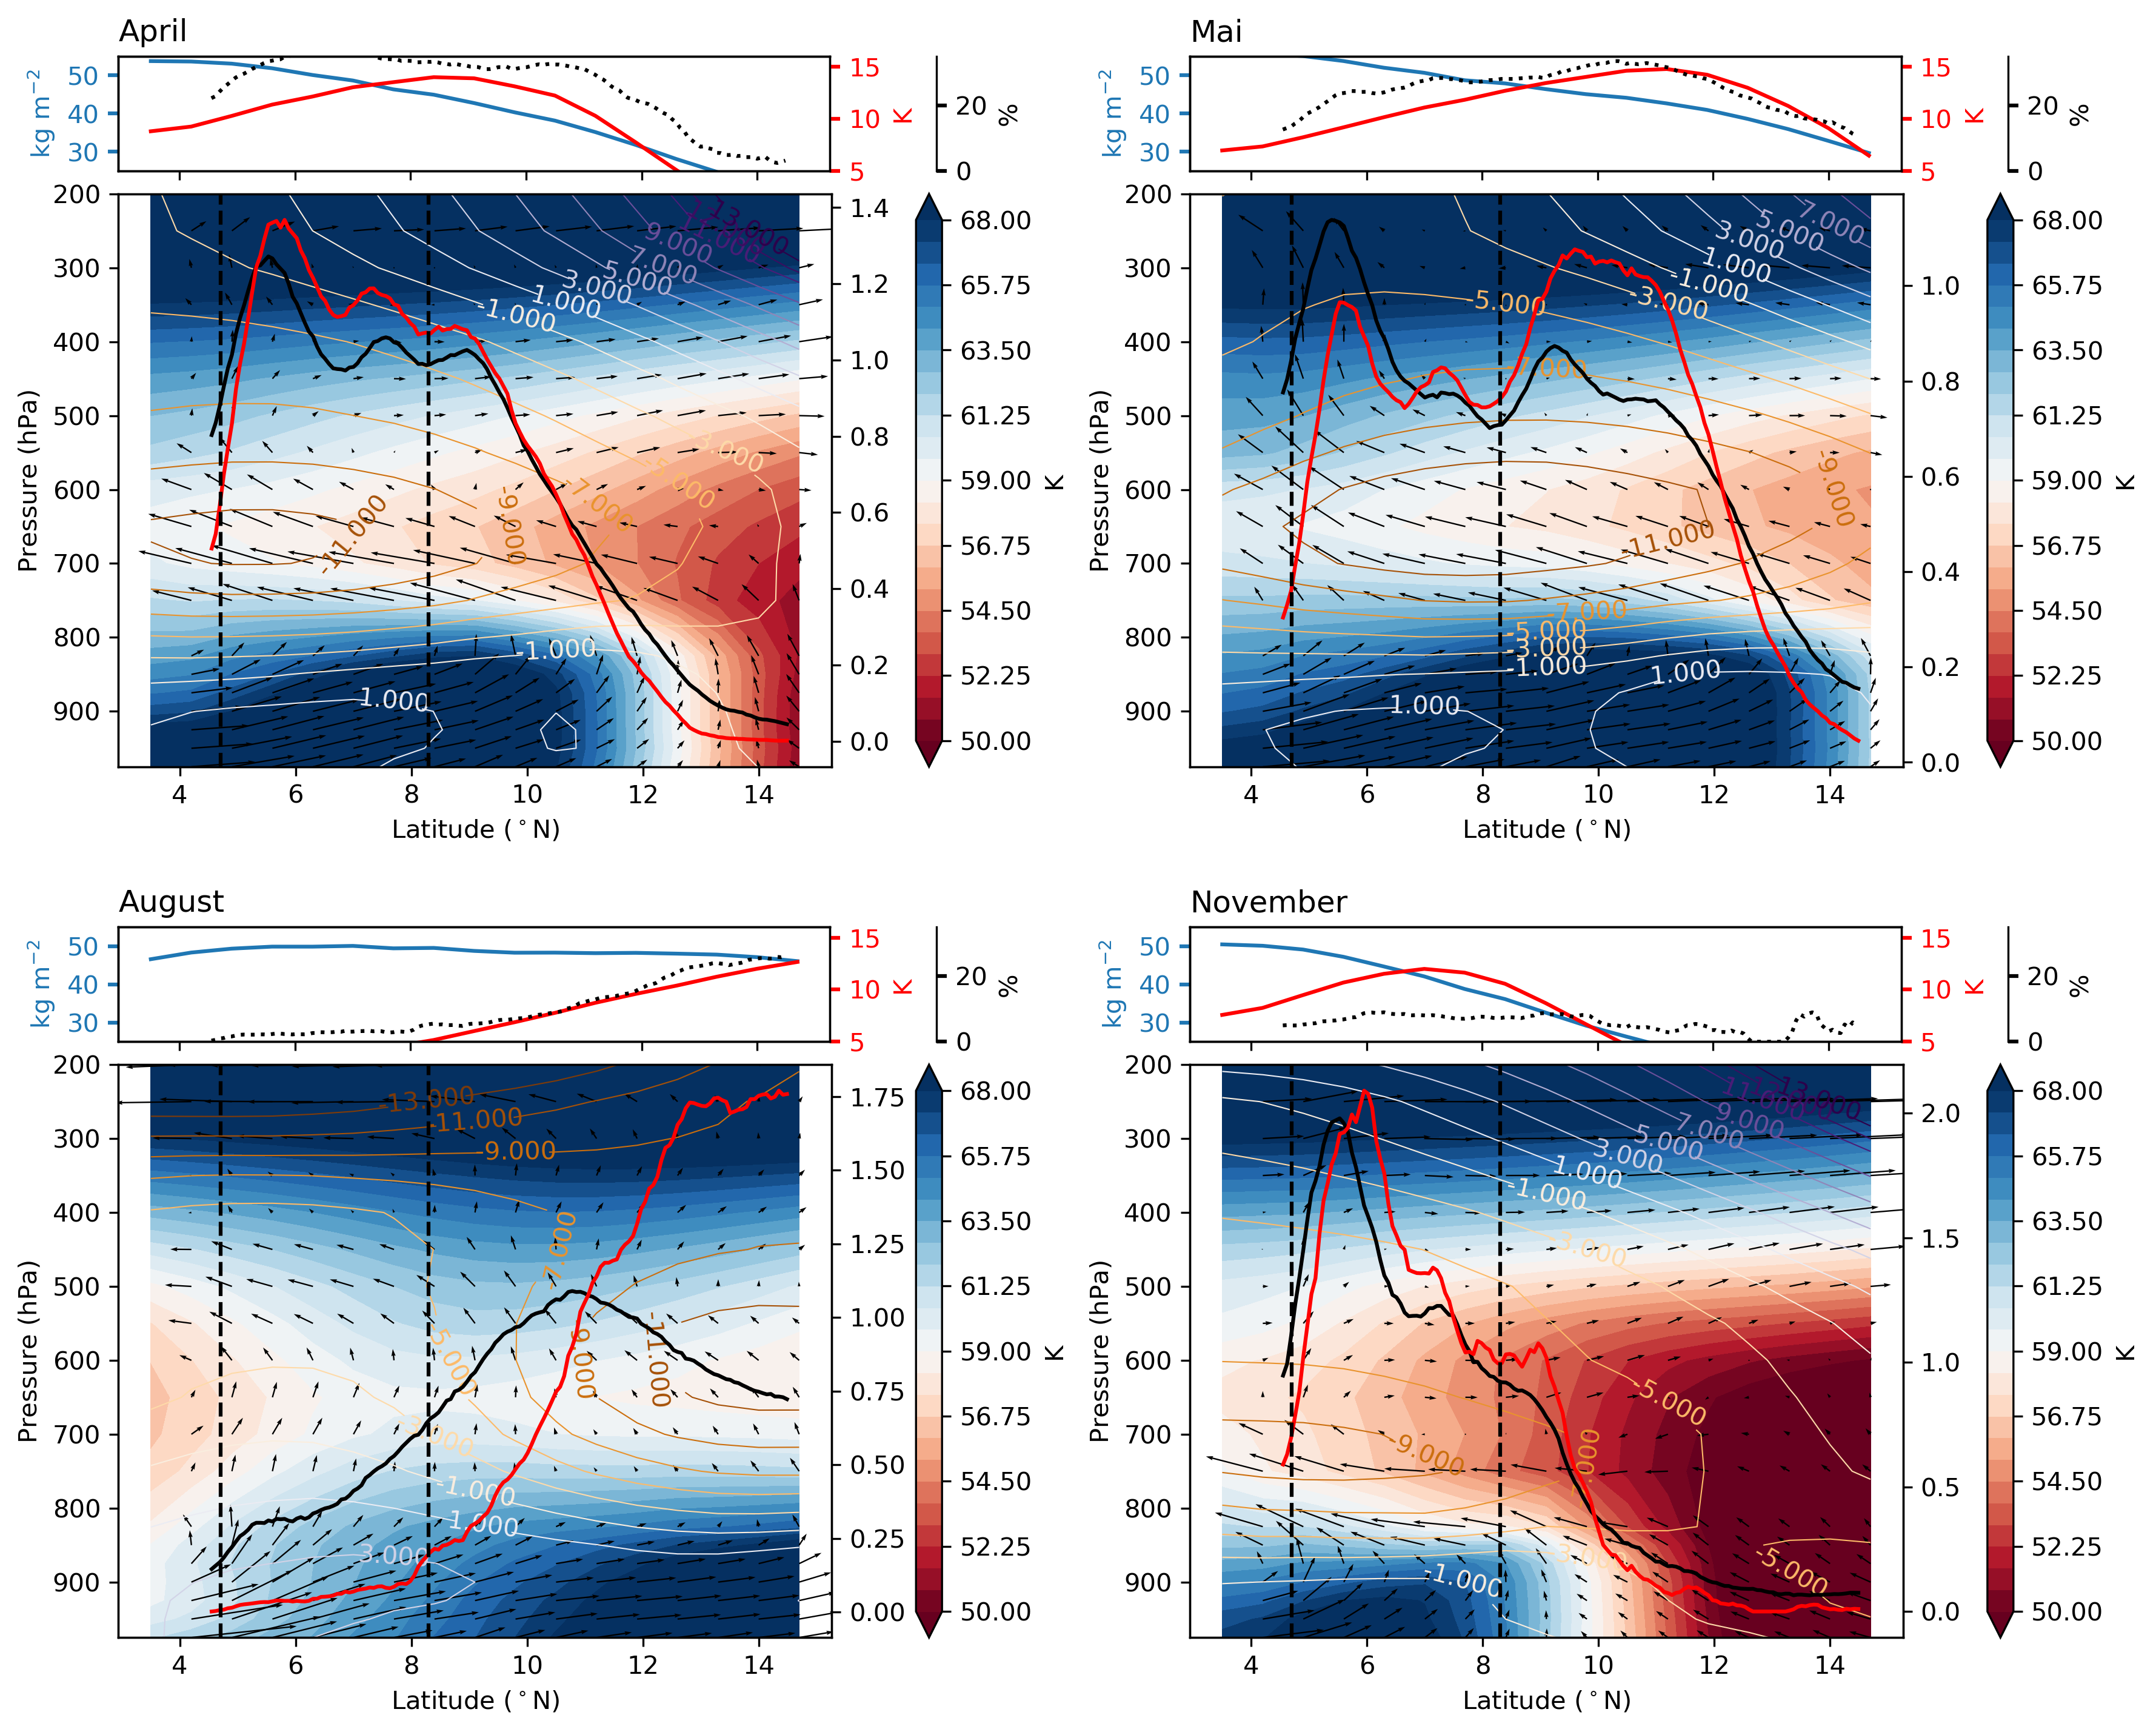

In [442]:

f=plt.figure(figsize=(12,9), dpi=300)  # this opens a plot window

left, width, width2 = 0.061, 0.43, 0.326#0.345
space=0.014
left2 = left + width + left

bottom, height, height2 = 0.09, 0.35, 0.07
bottom1 = bottom + height + space


bottom2 = bottom+height + height2 + space*8
bottom22 = bottom2  + height + space

cross1 = [left, bottom, width, height]
cross2 = [left+width+left, bottom, width, height]
line1 = [left, bottom1, width2, height2]
line2 = [left+width+left, bottom1, width2, height2]

cross3 = [left, bottom2, width, height]
cross4 = [left+width+left, bottom2, width, height]
line3 = [left, bottom22, width2, height2]
line4 = [left+width+left, bottom22, width2, height2]

pdic = {4 : (cross3,line3, 'April'), 5 : (cross4, line4, 'Mai'), 8 : (cross1, line1, 'August'), 11 : (cross2, line2, 'November') }

for k in pdic.keys():#ids, m in enumerate(np.array([3,6,9,10])):
    
    m = k
    p1 = pdic[k][0]
    p2 = pdic[k][1]
    mname = pdic[k][2]
    
    vdic = sel_month(m)

#     ax = plt.axes(p1)#f.add_subplot(2,2,ids+1)
#     t2 = np.repeat(vdic['ERA_srfc']['t2m'].values, repeats = len(vdic['ERA_pl'].level), axis=0).reshape((len(vdic['ERA_srfc']['t2m'].values), len(vdic['ERA_pl'].level))).T
#     cs = ax.contour(vdic['ERA_srfc'].latitude,vdic['ERA_pl'].level, t2-273.15, levels=np.arange(25,36,1))
#     plt.clabel(cs, inline=1, fontsize=10)
    
    # "current zonal wind" wind vectors
    vano = vdic['ERA_pl']['v']
    wano = vdic['ERA_pl']['w']*(-10)  # multiplied by 10 since vertical component is very small compared to horizontal one
    st=1
    sarrow = 1
    xquiv = vdic['ERA_pl'].latitude[sarrow::st]
    yquiv = vdic['ERA_pl'].level

    uu = (vano)[::, sarrow::st]  
    ww = (wano)[::, sarrow::st]

    qin = {'x' : xquiv, 'y' : yquiv, 'u' : uu, 'v' : ww, 'scale' : 30}

    # temperature and moisture check
    data = (vdic['ERA_pl']['u'])
    data2 = vdic['theta_e']
    #data2 = (vdic['ERA_pl']['r'])
    ax = plt.axes(p1)
    contour = {'data' : data, 'x' : vdic['ERA_pl'].latitude, 'y' : vdic['ERA_pl'].level, 'levels' : [-13,-11,-9,-7,-5,-3,-1,1,3,5,7,9,11,12,13], 'cmap' : 'PuOr'}
    draw_cross(ax, data2, vdic['ERA_pl'].latitude, vdic['ERA_pl'].level, cmap='RdBu', 
               levels=np.linspace(50,68,25), quiver=qin, contour=contour, cbar_label='K')
    
    ax2 = ax.twinx()
    ax2.plot(vdic['cover40'].lat,vdic['cover40'].values/np.sum(vdic['cover40'].values)*100, '-k')
    ax2.plot(vdic['cover70'].lat,vdic['cover70'].values/np.sum(vdic['cover70'].values)*100, '-r')
    

    plt.axvline(x=4.7, color='k', linestyle='dashed')
    plt.axvline(x=8.3, color='k', linestyle='dashed')

    ax1 = plt.axes(p2)#ax.twinx()
    ax1.set_xticklabels([])
    #ax1.plot(vdic['CHIRPS'].lat, vdic['CHIRPS']['precip'].values/np.sum(vdic['CHIRPS']['precip'].values)*100)
    #ax1.set_ylim(0,300)

    #ax2 = ax1.twinx()
    #ax2.spines["right"].set_position(("axes", 1.15))
#     f70 = vdic['cover70'].values/np.sum(vdic['cover70'].values)*100
#     f50 = vdic['cover50'].values/np.sum(vdic['cover50'].values)*100
#     ax1.plot(vdic['cover70'].lat, f70, '-ro')
    #ax2.plot(vdic['meanT_-50'].lat,vdic['meanT_-50'].values, '-ro')
    #ax2.set_ylim(0,0.18)

    #ax2 = ax.twinx()
    #ax2.spines["right"].set_position(("axes", 1.15))
    #ax1.plot(vdic['cover50'].lat, f50, '-go')
    #ax2.set_ylim(0,0.18)
    # ax3 = ax.twinx()
    # ax3.spines["right"].#set_position(("axes", 1.15))
    # ax3.plot(latbin,ext_frac_m, '-go')

    #ax4 = ax1.twinx()
     # ax4.spines["right"].set_position(("axes", 1.15))
    # ax4.plot(latbin,ext_abs_m, '-yo')
    pl1, = ax1.plot(vdic['ERA_pl'].latitude,vdic['ERA_srfc']['tcwv'])
    ax1.set_title(mname, loc='left', fontsize=12)
    ax1.set_ylabel(r'kg m$^{-2}$')
    ax1.set_ylim(25,55)
    ax5 = ax1.twinx()
    #ax5.spines["right"].set_position(("axes", 1.15))
    
    #ax7 = ax1.twinx()
    #pl7, = ax5.plot(vdic['ERA_pl'].latitude, vdic['ERA_pl']['q'].sel(level=slice(900,950)).mean('level')*1000, '-b')
    
    pl5, = ax5.plot(vdic['ERA_pl'].latitude, vdic['theta_e'][15:18,:].mean(axis=0)-vdic['theta_e'][8:11,:].mean(axis=0), '-r')
    ax5.set_ylim(5,16)
    ax5.set_ylabel('K')
    
    ax6 = ax1.twinx()
    ax6.spines["right"].set_position(("axes", 1.15))
    pl6, = ax6.plot(vdic['cover50'].lat,vdic['cover70'].values/vdic['cover50'].values*100, 'k', linestyle='dotted')
    ax6.set_ylim(0,35)
    ax6.set_ylabel('%')
    
    ax1.yaxis.label.set_color(pl1.get_color())
    ax5.yaxis.label.set_color(pl5.get_color())
    ax6.yaxis.label.set_color(pl6.get_color())
    
    tkw = dict(size=4, width=1.5)
    ax1.tick_params(axis='y', colors=pl1.get_color(), **tkw)
    ax5.tick_params(axis='y', colors=pl5.get_color(), **tkw)
    ax6.tick_params(axis='y', colors=pl6.get_color(), **tkw)
    
plt.tight_layout()

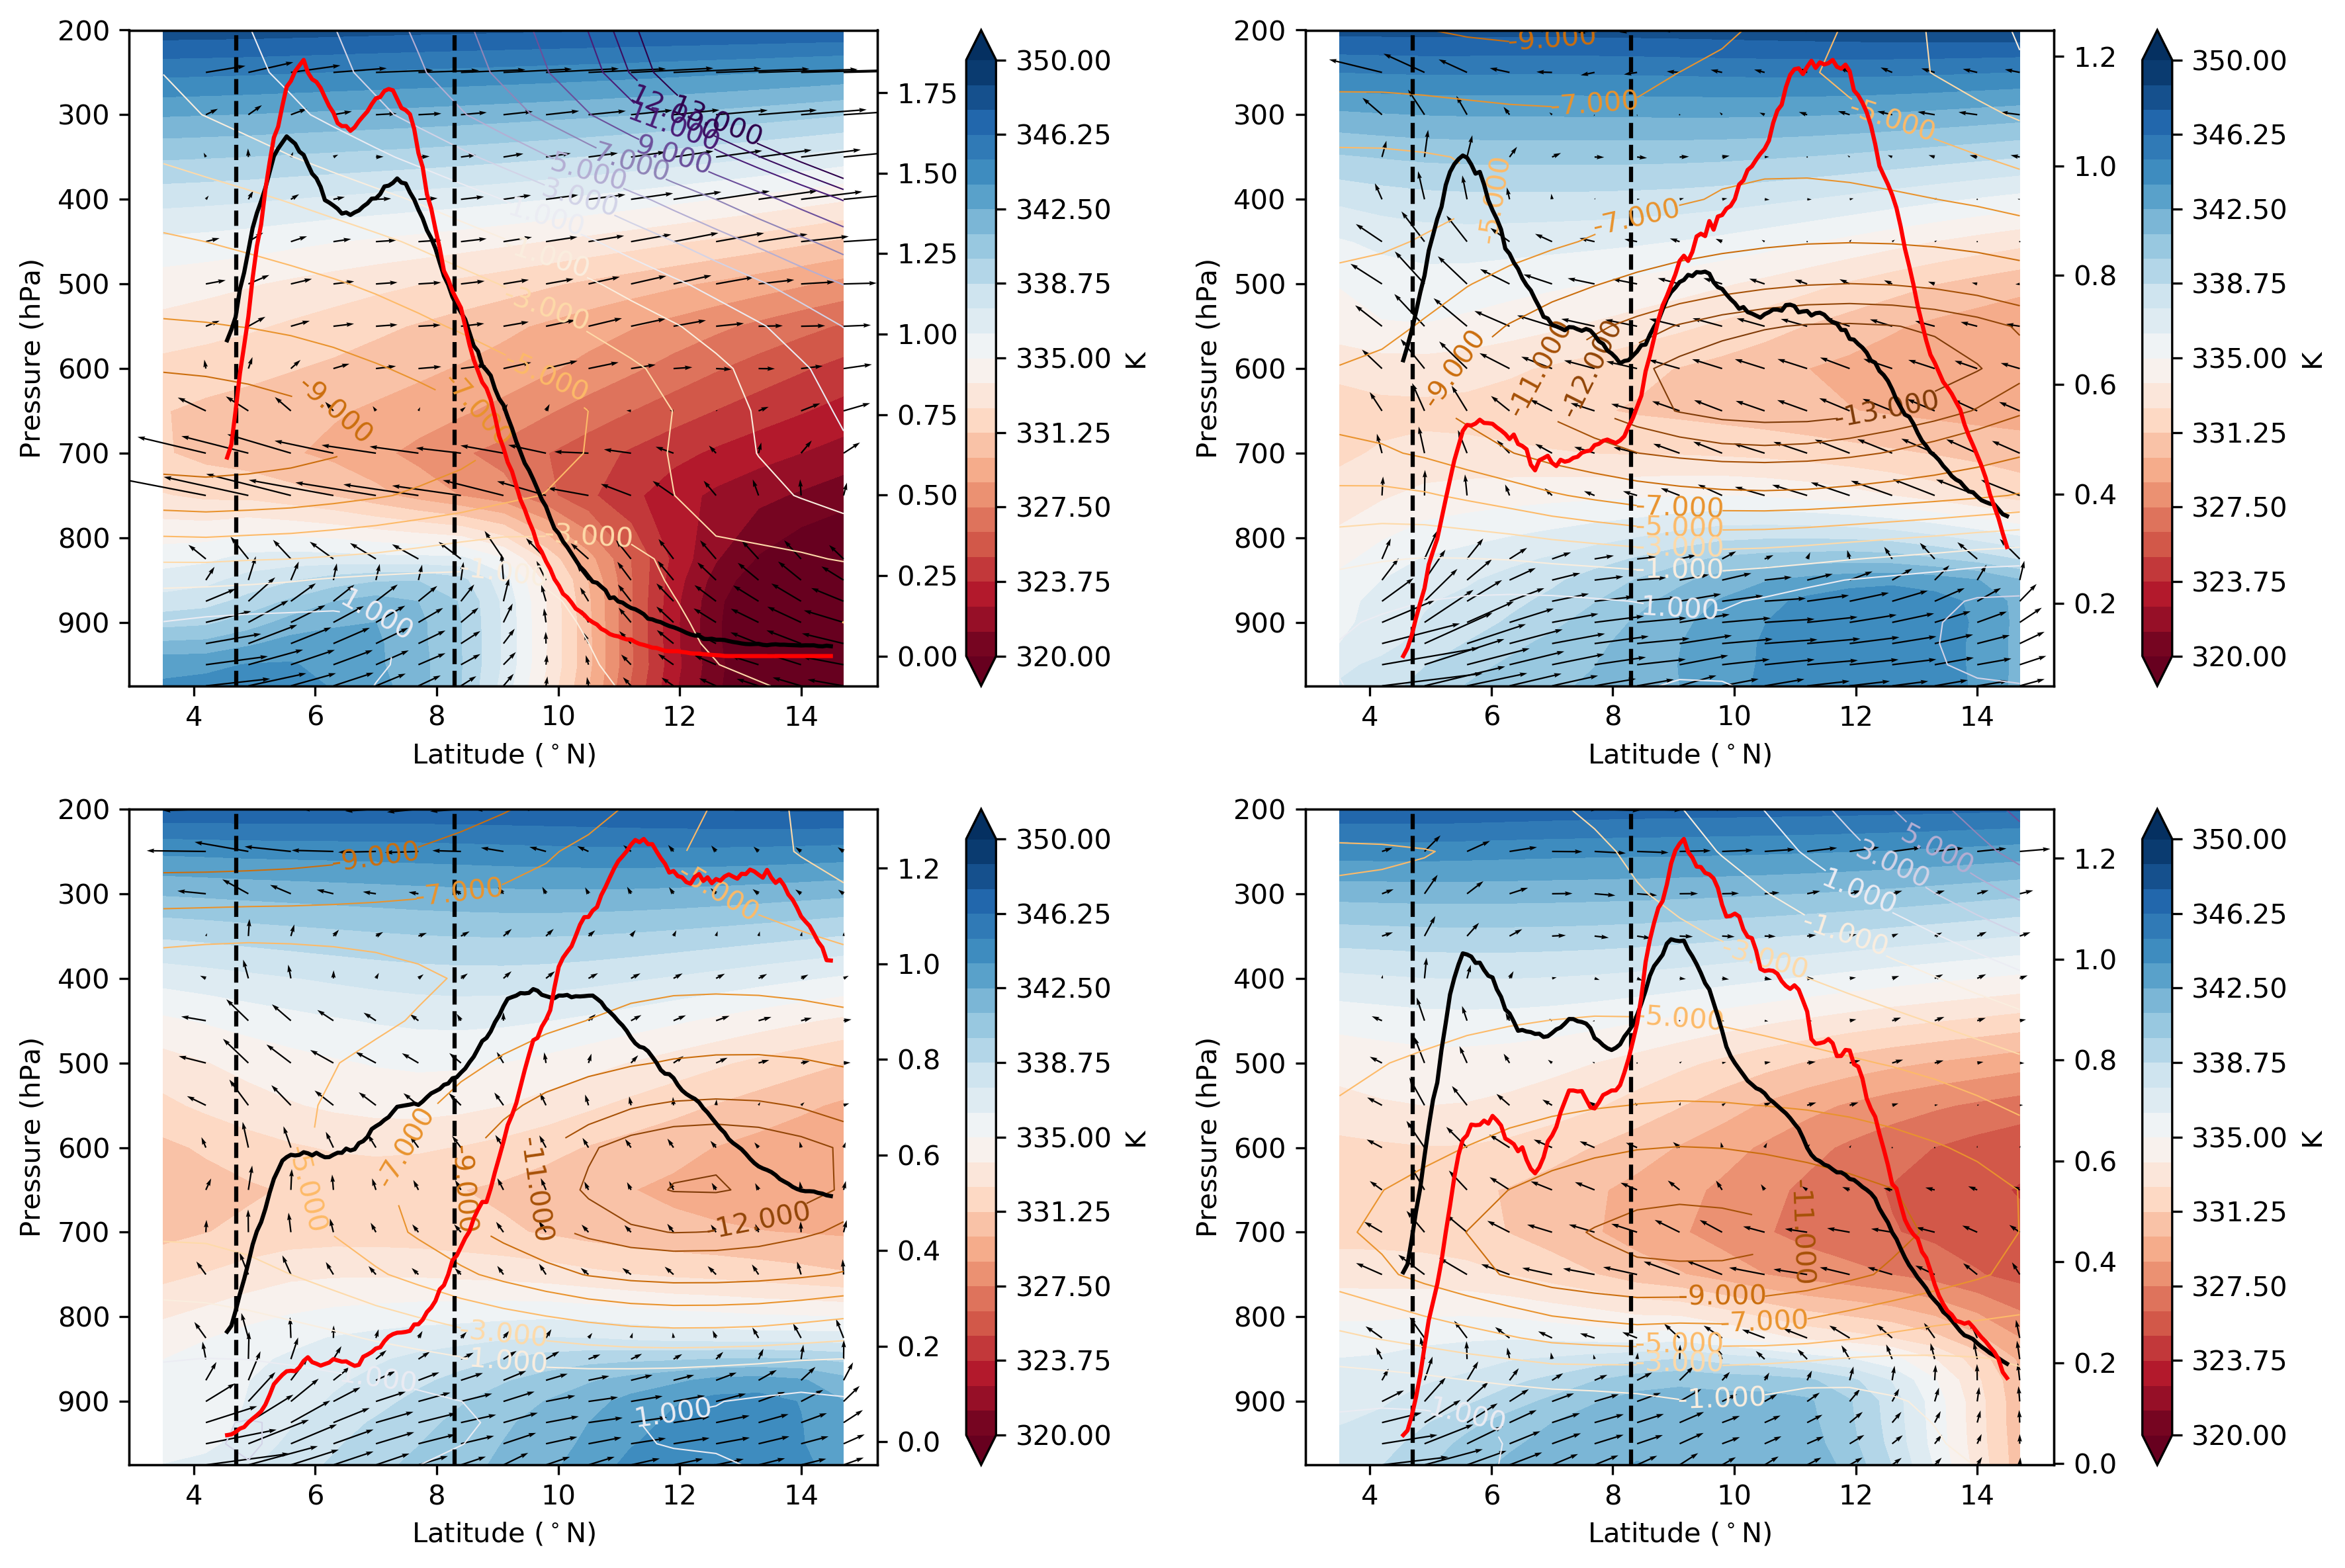

In [412]:

f=plt.figure(figsize=(12,8), dpi=300)  # this opens a plot window

for ids, m in enumerate(np.array([3,6,9,10])):
    
    vdic = sel_month(m)

    ax = f.add_subplot(2,2,ids+1)

    # "current zonal wind" wind vectors
    vano = vdic['ERA_pl']['v']
    wano = vdic['ERA_pl']['w']*(-10)  # multiplied by 10 since vertical component is very small compared to horizontal one
    st=1
    sarrow = 1
    xquiv = vdic['ERA_pl'].latitude[sarrow::st]
    yquiv = vdic['ERA_pl'].level

    uu = (vano)[::, sarrow::st]  
    ww = (wano)[::, sarrow::st]

    qin = {'x' : xquiv, 'y' : yquiv, 'u' : uu, 'v' : ww, 'scale' : 30}

    # temperature and moisture check
    data = (vdic['ERA_pl']['u'])
    #data2 = np.array(vdic['theta'])-np.mean(vdic['theta'][10,:])
    data2 = (vdic['theta_e']+273.15)
    contour = {'data' : data, 'x' : vdic['ERA_pl'].latitude, 'y' : vdic['ERA_pl'].level, 'levels' : [-13,-12,-11,-9,-7,-5,-3,-1,1,3,5,7,9,11,12,13], 'cmap' : 'PuOr'}
    draw_cross(ax, data2, vdic['ERA_pl'].latitude, vdic['ERA_pl'].level, cmap='RdBu', 
               levels=np.linspace(320,350,25), quiver=qin, contour=contour, cbar_label='K')


    plt.axvline(x=4.7, color='k', linestyle='dashed')
    plt.axvline(x=8.3, color='k', linestyle='dashed')

    ax1 = ax.twinx()
    #ax1.spines["right"].set_position(("axes", 1.15))
    #ax1.plot(vdic['CHIRPS'].lat, (vdic['CHIRPS']['precip'].values)/np.sum(vdic['CHIRPS']['precip'].values)*100)
    #ax1.set_ylim(0,300)

    #ax2 = ax.twinx()
    #ax2.spines["right"].set_position(("axes", 1.15))
    #ax1.plot(vdic['cover70'].lat,vdic['cover70'].values/np.sum(vdic['cover70'].values)*100, '-ko')
    #ax2.set_ylim(0,0.18)

    #ax2 = ax.twinx()
    #ax2.spines["right"].set_position(("axes", 1.15))
    ax1.plot(vdic['cover40'].lat,vdic['cover40'].values/np.sum(vdic['cover40'].values)*100, '-k')
    ax1.plot(vdic['cover70'].lat,vdic['cover70'].values/np.sum(vdic['cover70'].values)*100, '-r')
#     f70 = vdic['cover70'].values/np.sum(vdic['cover70'].values)*100
#     f50 = (vdic['cover40'].values/np.sum(vdic['cover40'].values))*100
    
#     perc = (vdic['cover70'].values / vdic['cover40'].values) * 100
#     avg_perc = np.sum(vdic['cover70'].values) / np.sum(vdic['cover40'].values) * 100

    #ax1.plot(vdic['cover50'].lat, perc-avg_perc, '-kx')
#     ax1.set_ylim(-10,10)
    # ax3 = ax.twinx()
    # ax3.spines["right"].#set_position(("axes", 1.15))
    # ax3.plot(latbin,ext_frac_m, '-go')

    # ax4 = ax.twinx()
    # ax4.spines["right"].set_position(("axes", 1.15))
    # ax4.plot(latbin,ext_abs_m, '-yo')

#     ax4 = ax.twinx()
#     ax4.spines["right"].set_position(("axes", 1.15))
#     ax4.plot(latbin,np.array(vdic['extreme70Frac50'])*100, '-ro')
plt.tight_layout()

In [332]:
perc

array([ 3.593699 ,  3.7937443,  4.399999 ,  4.9305267,  5.291255 ,
        5.8318253,  6.209015 ,  6.377175 ,  6.7475357,  6.941489 ,
        7.3865542,  7.681669 ,  8.138066 ,  8.418831 ,  8.534737 ,
        8.564596 ,  8.874939 ,  8.931133 ,  8.989858 ,  9.100047 ,
        9.168405 ,  9.307517 ,  9.529708 ,  9.67595  ,  9.570498 ,
        9.791595 , 10.057562 , 10.05136  , 10.1965685, 10.185539 ,
       10.35134  , 10.423632 , 10.470995 , 10.74666  , 11.162994 ,
       11.130141 , 11.118589 , 11.305192 , 11.436527 , 11.416071 ,
       11.337355 , 11.178379 , 10.674906 ,  9.998616 ,  9.624537 ,
        9.41397  ,  9.666753 ,  9.717672 ,  9.427049 ,  9.260909 ,
        8.966942 ,  8.751057 ,  8.791209 ,  9.032006 ,  9.212118 ,
        9.27418  ,  9.564653 ,  9.969066 , 10.060461 , 10.356553 ,
       10.408922 , 10.406846 , 10.500379 , 10.821905 , 11.078392 ,
       11.316626 , 11.467585 , 11.660953 , 11.651382 , 11.710491 ,
       12.027402 , 12.21981  , 12.4759445, 12.884775 , 13.1605

In [317]:
np.sum(vdic['cover50'].values)

354.71338

In [318]:
vdic['cover50'].values / np.sum(vdic['cover50'].values)

array([0.00343258, 0.00363761, 0.00422454, 0.00480387, 0.00538122,
       0.0060656 , 0.00678574, 0.00743266, 0.00780104, 0.00847161,
       0.00915458, 0.00977446, 0.01026451, 0.01067823, 0.0109655 ,
       0.01107196, 0.01103704, 0.01099282, 0.0109962 , 0.01092805,
       0.01080356, 0.01085088, 0.0106895 , 0.01050756, 0.01034083,
       0.01008145, 0.00983445, 0.00970603, 0.00971419, 0.00954775,
       0.00939482, 0.00926752, 0.00919063, 0.00904136, 0.00898673,
       0.00887914, 0.00878705, 0.00870678, 0.00859694, 0.0084964 ,
       0.00845105, 0.00832685, 0.00824997, 0.00814323, 0.00798861,
       0.00781428, 0.00766529, 0.00765121, 0.00760924, 0.00759066,
       0.00764163, 0.00766923, 0.00784244, 0.00791088, 0.0079213 ,
       0.00807479, 0.0082418 , 0.00846683, 0.00866425, 0.00886253,
       0.00901545, 0.0090822 , 0.00931511, 0.00946776, 0.0095638 ,
       0.00965364, 0.00973532, 0.00969223, 0.00973644, 0.00977869,
       0.00974348, 0.00959929, 0.00951282, 0.00940552, 0.00920